In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import xlearn

import optuna

import gc

import math

from sklearn.metrics import roc_auc_score, log_loss, roc_curve

In [31]:
PATH = './data.csv'
data = pd.read_csv(PATH)

Датасет состоит из показов рекламы.
- oaid_hash - хэш юзера
- date_time - время показа рекламы
- zone_id - id зоны, где зона - место на сайте для размещения рекламы
- banner_id - id баннера, где баннер - сама реклама
- campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. - - - Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
- os_id - id операционной системы
- country_id - id страны
- impressions - был ли показ
- clicks - был ли клик


Для Домашней работы 2, колонки: banner_id0, banner_id1, rate0, rate1, g0, g1, coeff_sum0, coeff_sum1 использовать не нужно! Они будут использоваться в последующих Домашних работах.

Прошлое дз (baseline был побит):
auc: 0.702188450129561,
log_loss: 0.1359679997059639

In [4]:
print(f"unique impressions: {data['impressions'].unique()}\n") # impressions все равны 1, их нет смысла брать

print(data.isnull().sum(axis = 0)) # по нашим столбцам NaN'ов нету

unique impressions: [1]

date_time              0
zone_id                0
banner_id              0
oaid_hash              0
campaign_clicks        0
os_id                  0
country_id             0
banner_id0             0
rate0                 69
g0                    69
coeff_sum0            69
banner_id1             0
rate1              19744
g1                 19744
coeff_sum1         19744
impressions            0
clicks                 0
dtype: int64


In [32]:
data['date_time'] = pd.to_datetime(data['date_time'])

<Axes: xlabel='date_time'>

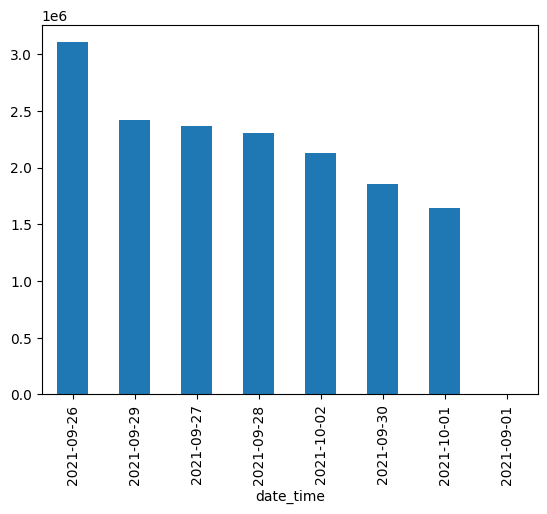

In [6]:
data['date_time'].dt.date.value_counts().plot(kind='bar')

Выброс -- 2021-09-01. Удалим его

In [33]:
data = data[data['date_time'].dt.date != pd.Timestamp('2021-09-01').date()]

In [34]:
# Вытащим используемые фичи

data = data[['oaid_hash', 'date_time', 'zone_id', 'os_id', 'banner_id', 'campaign_clicks', 'country_id', 'clicks']]
data.head()

,oaid_hash,date_time,zone_id,os_id,banner_id,campaign_clicks,country_id,clicks
0,5664530014561852622,2021-09-27 00:01:30,0,0,0,0,0,1
1,5186611064559013950,2021-09-26 22:54:49,1,0,1,0,1,1
2,2215519569292448030,2021-09-26 23:57:20,2,0,2,3,0,1
3,6262169206735077204,2021-09-27 00:04:30,3,1,3,0,1,1
4,4778985830203613115,2021-09-27 00:06:21,4,1,4,0,0,1


In [35]:
# переведем даты в дни недели и часы, переведем все числовые данные в тип, который занимает меньший объем памяти
numeric_cols = data.select_dtypes(include='number').columns.tolist()
print(f"oaid_hash maximal: {data['oaid_hash'].max()}")
numeric_cols.remove('oaid_hash') # oaid_hash трогать не будем, для него тип подходит
print(f"numeric cols: {numeric_cols}")

oaid_hash maximal: 9223371107563590722
numeric cols: ['zone_id', 'os_id', 'banner_id', 'campaign_clicks', 'country_id', 'clicks']


In [36]:
data[numeric_cols] = data[numeric_cols].astype('int16')
data['date_time'] = pd.to_datetime(data['date_time'])
data['hour'] = data['date_time'].dt.hour.astype('int16')
data['day_number'] = data['date_time'].dt.weekday.astype('int16')

Перед анализом данных уберем тестовую выборку

In [37]:
# разделим данные на трейн и тест. Оставим у train столбец date_time, он пригодится для отделения валидации
max_date = data['date_time'].dt.date.max()
test_data = data[data['date_time'].dt.date == max_date].drop(columns=['date_time'])
train_data = data[data['date_time'].dt.date < max_date]

gc.collect()

1362

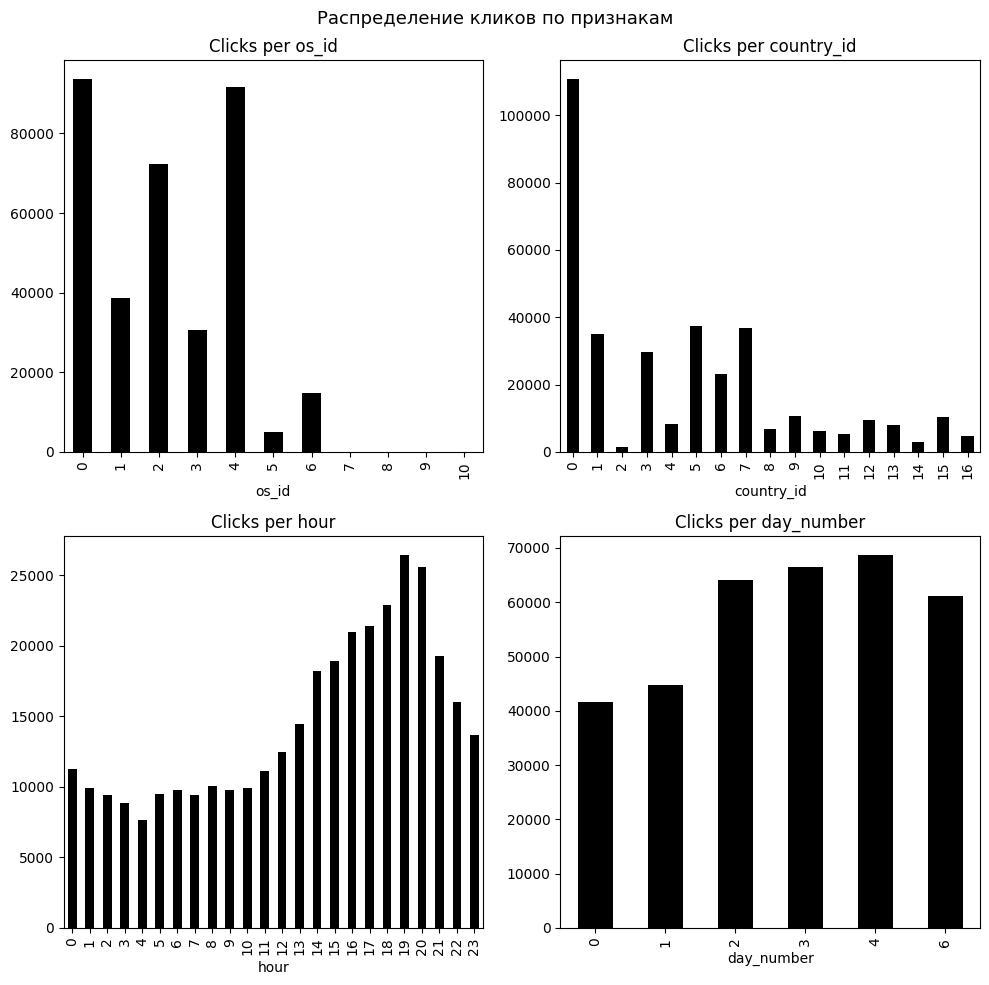

In [12]:
# Посмотрим на кол-во кликов по разным фичам. Сперва посмотрим на более удобные в отображении признаки

features_1 = ['os_id', 'country_id', 'hour', 'day_number']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plot_index = 0

for i in range(2):
    for j in range(2):
        clicks_per_feature = train_data.groupby(features_1[plot_index])['clicks'].sum()
        ax = axs[i, j]
        clicks_per_feature.plot(kind='bar', color='black', ax=ax)
        ax.set_title(f'Clicks per {features_1[plot_index]}')
        plot_index += 1

fig.suptitle('Распределение кликов по признакам', fontsize=13)
plt.tight_layout()
plt.show()

Количество кликов по этим признакам распределено довольно разнообразно, выбросов мало. Единственное, что бросается в глаза, это то, что `os_id` практически нет в категориях выше 6. В`country_id` практически пустых значений нет, но можно тоже объединить.

In [13]:
# посчитаем категории os_id
print("without normalise")
print(train_data['os_id'].value_counts())
print("\nwith normalise")
print(train_data['os_id'].value_counts(normalize=True))

without normalise
os_id
2     4099560
0     3279152
1     2773802
4     2531697
3      651830
6      257782
5       97525
8        1017
7          99
9          24
10          5
Name: count, dtype: int64

with normalise
os_id
2     2.994020e-01
0     2.394854e-01
1     2.025783e-01
4     1.848967e-01
3     4.760492e-02
6     1.882652e-02
5     7.122516e-03
8     7.427428e-05
7     7.230239e-06
9     1.752785e-06
10    3.651636e-07
Name: proportion, dtype: float64


Объединим все, что меньше 1e-3, в новую категорию. Так как `os` существует не так много, то новый номер можно выбрать не очень большой

In [14]:
# аналогично с country_id
print("without normalise")
print(train_data['country_id'].value_counts())
print("\nwithout normalise")
print(train_data['country_id'].value_counts(normalize=True))

without normalise
country_id
0     4268040
5     1689814
6     1394561
7     1373117
1     1154254
3     1074344
15     540412
12     419898
9      354648
10     339790
4      335702
11     188816
8      170027
13     159744
14     115615
16      64866
2       48845
Name: count, dtype: int64

without normalise
country_id
0     0.311707
5     0.123412
6     0.101849
7     0.100282
1     0.084298
3     0.078462
15    0.039468
12    0.030666
9     0.025901
10    0.024816
4     0.024517
11    0.013790
8     0.012418
13    0.011667
14    0.008444
16    0.004737
2     0.003567
Name: proportion, dtype: float64


Объединим все, что меньше 1e-2, в новую категорию. Так как стран тоже ограниченное кол-во, выберем номер новой категории 200

In [38]:
def reassign(df, column_name, threshold, new_category, normalize=True):
    category_counts = df[column_name].value_counts(normalize=normalize)
    rare_categories = category_counts[category_counts < threshold].index.tolist()
    df.loc[df[column_name].isin(rare_categories), column_name] = new_category
    return df

In [39]:
train_data = reassign(train_data, 'os_id', 1e-3, 20)
train_data = reassign(train_data, 'country_id', 1e-2, 200)

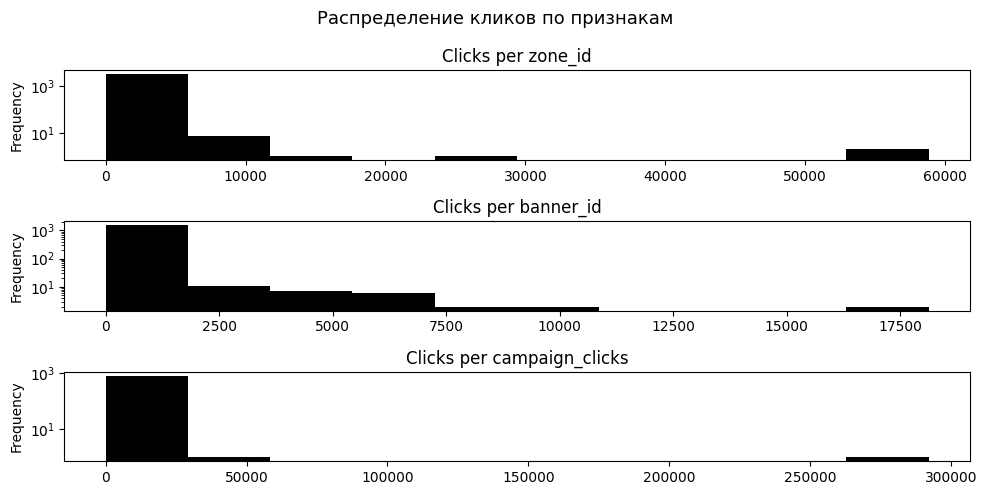

In [17]:
features_2 = ['zone_id', 'banner_id', 'campaign_clicks']

fig, axs = plt.subplots(3, 1, figsize=(10, 5))
plot_index = 0

for j in range(3):
    clicks_per_feature = train_data.groupby(features_2[plot_index])['clicks'].sum()
    ax = axs[j]
    clicks_per_feature.plot(kind='hist', color='black', ax=ax, logy=True)
    ax.set_title(f'Clicks per {features_2[plot_index]}')
    plot_index += 1

fig.suptitle('Распределение кликов по признакам', fontsize=13)
plt.tight_layout()
plt.show()

Ну тут распределение какое-то менее приятное получилось. Тоже объединим редкие категории (по порогу 1e-3)

In [40]:
class_zone_id =  train_data['zone_id'].max() + 500
class_banner_id = train_data['banner_id'].max() + 500
train_data = reassign(train_data, 'zone_id', 1e-3, class_zone_id)
train_data = reassign(train_data, 'banner_id', 1e-2, class_banner_id)
print(class_zone_id, class_banner_id)

3943 2132


In [19]:
print(train_data['oaid_hash'].value_counts(normalize=True))
print(f"\nNumber of rare hashes: {(train_data['oaid_hash'].value_counts() < 5).sum()}")

oaid_hash
308174966294367527     3.409167e-04
2890718152668627077    1.833852e-04
2521895603443866206    1.671719e-04
8212556321845734673    1.441666e-04
3375698397737628939    1.430711e-04
                           ...     
232745324250944698     7.303272e-08
8635129584864552187    7.303272e-08
7590420289968071067    7.303272e-08
2965446629425844749    7.303272e-08
453968700792456599     7.303272e-08
Name: proportion, Length: 5660417, dtype: float64

Number of rare hashes: 5130185


In [20]:
train_data['oaid_hash'].min()

1116910879938

Видим большое количество редко встречающихся хэшей. Их лучше убрать. Так как хэши ограничены снизу довольно большими числами, то присвоим им класс 0

In [41]:
train_data = reassign(train_data, 'oaid_hash', 5, 0, False)

Отделим теперь выборку, на которой будем валидироваться

In [42]:
max_date = train_data['date_time'].dt.date.max()
val_data = train_data[data['date_time'].dt.date == max_date].drop(columns=['date_time'])
train_data = train_data[data['date_time'].dt.date < max_date].drop(columns=['date_time'])

C:\Users\amoseichuk\AppData\Local\Temp\ipykernel_21884\743699599.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_data = train_data[data['date_time'].dt.date == max_date].drop(columns=['date_time'])
C:\Users\amoseichuk\AppData\Local\Temp\ipykernel_21884\743699599.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data = train_data[data['date_time'].dt.date < max_date].drop(columns=['date_time'])


In [45]:
def prepare_test(test_data):
    test_data = reassign(test_data, 'os_id', 1e-3, 20)
    test_data = reassign(test_data, 'country_id', 1e-2, 200)
    test_data = reassign(test_data, 'zone_id', 1e-3, class_zone_id)
    test_data = reassign(test_data, 'banner_id', 1e-2, class_banner_id)
    test_data = reassign(test_data, 'oaid_hash', 5, 0, False)
    return test_data

In [46]:
test_data = prepare_test(test_data)

In [47]:
print(train_data.info())
print(val_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12049045 entries, 0 to 15821471
Data columns (total 9 columns):
 #   Column           Dtype
---  ------           -----
 0   oaid_hash        int64
 1   zone_id          int16
 2   os_id            int16
 3   banner_id        int16
 4   campaign_clicks  int16
 5   country_id       int16
 6   clicks           int16
 7   hour             int16
 8   day_number       int16
dtypes: int16(8), int64(1)
memory usage: 367.7 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643448 entries, 59 to 15821466
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype
---  ------           --------------    -----
 0   oaid_hash        1643448 non-null  int64
 1   zone_id          1643448 non-null  int16
 2   os_id            1643448 non-null  int16
 3   banner_id        1643448 non-null  int16
 4   campaign_clicks  1643448 non-null  int16
 5   country_id       1643448 non-null  int16
 6   clicks           1643448 non-null  i

In [51]:
# смотрел сюда https://github.com/aksnzhy/xlearn_doc/blob/master/python_api/index.rst
# и сюда https://github.com/ycjuan/libffm/blob/master/README
# и сюда https://github.com/SongDark/libffm_converter/blob/master/libffm_converter.py
# и еще куда-то тоже смотрел
# libffm format: label field_1:index_1:value_1 field_2:index_2:value_2 ...

from tqdm.notebook import tqdm

curr_code = 0
dict_field = {} 

In [52]:
def libffm(filename, data, target_column, categorical_features):
    global curr_code, dict_field
    with open(filename, "w") as f:
        for index, row in tqdm(data.iterrows()):
            parse_row(row, target_column, categorical_features, f)

def parse_row(row, target_column, categorical_features, f):
    global curr_code
    f.write(str(row[target_column]))
    for i, feature in enumerate(categorical_features):
        if feature not in dict_field:
            dict_field[feature] = {}
            curr_code += 1
            dict_field[feature][row[feature]] = curr_code
        elif row[feature] not in dict_field[feature]:
            curr_code += 1
            dict_field[feature][row[feature]] = curr_code
        f.write(f' {i}:{dict_field[feature][row[feature]]}:1')
    f.write('\n')

In [53]:
train, val, test = "train.txt", "validation.txt", "test.txt" 
target_column = "clicks"
categorical_features = ['oaid_hash', 'zone_id', 'os_id', 'banner_id', 'country_id', 'hour', 'day_number']

In [54]:
libffm(train, train_data, target_column, categorical_features)

0it [00:00, ?it/s]

In [55]:
libffm(val, val_data, target_column, categorical_features)
libffm(test, test_data, target_column, categorical_features)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [27]:
y_val = val_data['clicks']

In [30]:
def objective(trial):

    c = trial.suggest_float("lambda", 0.0001, 3, log=True)
    lr = trial.suggest_float("lr", 0.01, 0.3, log=True)
    k = trial.suggest_int("k", 2, 16)
    
    params = {'task':'binary', 'lr': lr, 'lambda': с, 'k': k, 'metric': 'auc'}
    ffm_model = xlearn.create_ffm()
    ffm_model.setTrain('./train.txt')
    ffm_model.setTest('./validation.txt')
    ffm_model.fit(params, './model.out')
    ffm_model.setSigmoid()
    ffm_model.predict('./model.out', './res.txt')

    with open('res.txt', 'r') as f:
        y_pred_proba = np.array(list(map(float, filter(lambda s: len(s) > 0, f.read().split('\n')))))

    return roc_auc_score(y_val, y_pred_proba)

In [31]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, show_progress_bar=1)

[I 2023-12-05 02:10:55,607] A new study created in memory with name: no-name-7690abc5-e869-4076-9a27-131a535e7648


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-12-05 02:13:45,140] Trial 0 finished with value: 0.7487822996143102 and parameters: {'lambda': 0.046643477907612495, 'lr': 0.023781331002450078, 'k': 14}. Best is trial 0 with value: 0.7487822996143102.
[I 2023-12-05 02:16:59,226] Trial 1 finished with value: 0.7469889775834959 and parameters: {'lambda': 0.0004601385098088976, 'lr': 0.2808632538701753, 'k': 14}. Best is trial 0 with value: 0.7487822996143102.
[I 2023-12-05 02:19:35,336] Trial 2 finished with value: 0.7514268459349595 and parameters: {'lambda': 0.008818750049792042, 'lr': 0.13326406486792472, 'k': 11}. Best is trial 2 with value: 0.7514268459349595.
[I 2023-12-05 02:22:21,608] Trial 3 finished with value: 0.7484737024255163 and parameters: {'lambda': 0.0001257495305667381, 'lr': 0.17451298323940465, 'k': 12}. Best is trial 2 with value: 0.7514268459349595.
[I 2023-12-05 02:24:52,068] Trial 4 finished with value: 0.7513318431641844 and parameters: {'lambda': 1.487492086869331, 'lr': 0.041248498451725166, 'k': 9}.

Кросс-валидацию не использовал для экономии времени на обучение

In [32]:
study.best_params

{'lambda': 0.0027891460486388535, 'lr': 0.0701267281446324, 'k': 15}

Видно, что `k` уперлась в границу отрезка поиска и по хорошему надо бы сделать его больше и проверить. Но, к сожалению, это не влезет в память.  

Объединим валидацию с трейном.

In [40]:
with open("train.txt", 'r') as file1:
    file1_content = file1.read()
    
with open("validation.txt", 'r') as file2:
    file2_content = file2.read()

with open("full_train", 'w') as file3:
    file3.write(file1_content)
    file3.write(file2_content)

In [56]:
params = {'task': 'binary', 'metric': 'auc', 'lambda': 0.0027891460486388535, 'lr': 0.0701267281446324, 'k': 15}

In [57]:
y_test = test_data['clicks']

In [22]:
del test_data, train_data, val_data, data
gc.collect()

62

In [69]:
ffm_model = xlearn.create_ffm()
ffm_model.setTrain('./full_train')
ffm_model.setTest('./test.txt')
ffm_model.fit(params, './final_model.out')
ffm_model.setSigmoid()
ffm_model.predict('./final_model.out', './final_res.txt')

with open('./final_res.txt', 'r') as f:
    y_proba = np.array(list(map(float, filter(lambda s: len(s) > 0, f.read().split('\n')))))

In [70]:
log_loss = log_loss(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc}, log_loss: {log_loss}")

AUC: 0.7580856155431807, log_loss: 0.14321384845241147


AUC получился лучше, а log_loss немного хуже прошлого решения (auc: 0.702188450129561, log_loss: 0.1359679997059639)